In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

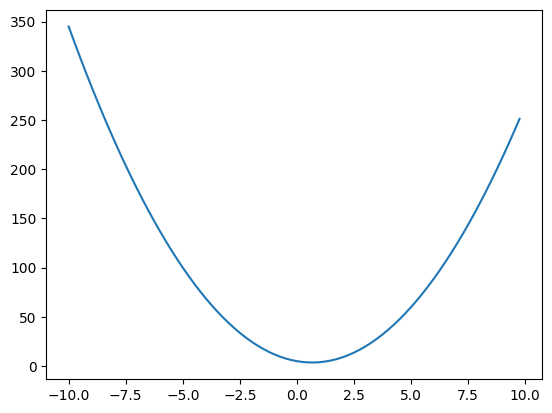

In [ ]:
xs = np.arange(-10, 10, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [17]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [19]:
a =2.0
b = -3.0
c =10.0
d=a*b+c
print(d)

4.0


In [25]:
h = 0.0001

#inputs
a =2.0
b = -3.0
c =10.0

d1=a*b+c
c+= h
d2 = a*b +c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [225]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  # Add __radd__ to handle operations like int + Value or float + Value
  def __radd__(self, other):
    return self + other # Delegate to the __add__ method

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other # Delegate to the __mul__ method

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  # Corrected exp method - indentation and backward pass
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
        # The derivative of exp(x) with respect to x is exp(x)
        # grad_x = grad_out * d(out)/dx = grad_out * exp(x)
        self.grad += out.data * out.grad # out.data is exp(x)
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1 # Uses __mul__ and __pow__

  def __neg__(self): # -self
    return self * -1 # Uses __mul__

  def __sub__(self, other): # self - other
    other = other if isinstance(other, Value) else Value(other) # Ensure other is Value
    return self + (-other) # Uses __add__ and __neg__

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      # Derivative of tanh(x) is 1 - tanh(x)**2
      # grad_x = grad_out * d(out)/dx = grad_out * (1 - tanh(x)**2)
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
     # This implementation seems correct for topological sort and backpropagation
     topo = []
     visited = set()
     def build_topo(v):
       if v not in visited:
         visited.add(v)
         for child in v._prev:
           build_topo(child)
         topo.append(v)

     # Kick off the topological sort from the current node (self)
     build_topo(self)

     # Set the gradient of the output (self) to 1.0
     self.grad = 1.0

     # Iterate through the sorted nodes in reverse order and apply backward pass
     for node in reversed(topo):
       node._backward()

In [179]:
a = Value(2.0)
b =Value(4.0)
a/b

value(data=0.5)

In [180]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+n2._op)
  return dot

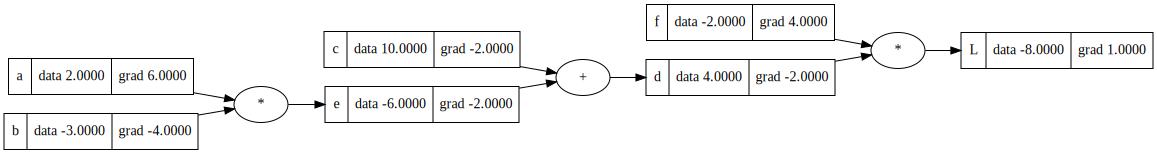

In [83]:
draw_dot(L)

In [85]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b;
d = e + c
L = d*f

print(L.data)

-6.586368000000001


In [79]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data


  print((L2-L1)/h)

lol()

-2.000000000000668


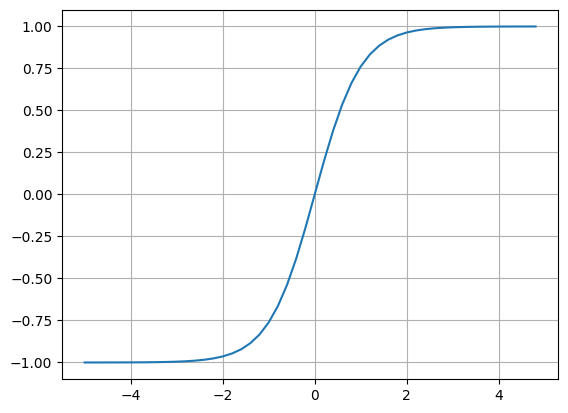

In [86]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();


In [186]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
e = (2*n).exp()
o = (e-1)/(e+1)
#----------

o.label = 'o'
o.backward()

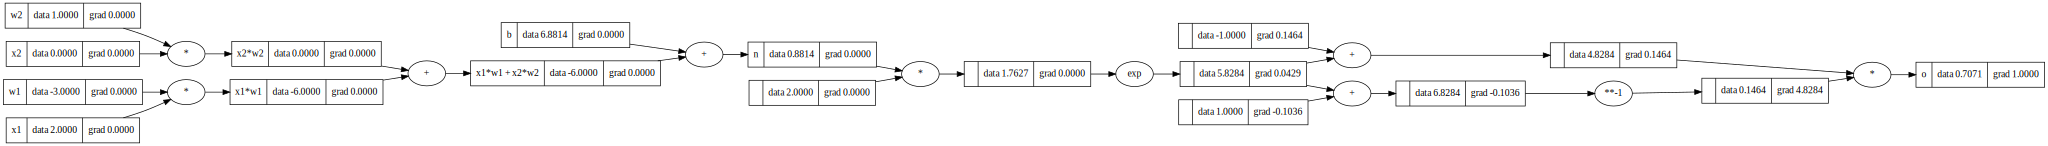

In [187]:

draw_dot(o)

In [188]:
import torch

In [190]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369


In [232]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # Ensure inputs x are also Value objects if not already
    x_values = [xi if isinstance(xi, Value) else Value(xi) for xi in x]
    # Perform the weighted sum iteratively
    act = self.b # Start with the bias (a Value object)
    for wi, xi in zip(self.w, x_values):
      act = act + wi * xi # Ensure addition is between Value objects

    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    # If x is a single Value object, wrap it in a list for iteration
    inputs = [x] if isinstance(x, Value) else x
    outs = [n(inputs) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    # Create layers. Ensure the output of each layer is passed as input to the next.
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    # Pass the output of each layer as the input to the next layer
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [233]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=0.8079081733940628)

In [235]:
xs =[
    [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
    [1.0 ,1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[value(data=0.8079081733940628),
 value(data=-0.038312672351603065),
 value(data=0.6816557721097056),
 value(data=0.8572702721551131)]

In [236]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

value(data=3.810079697088886)

In [270]:
for k in range(20):
  ypred = [n(x) for x in xs]
  # forwar dpass
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  #update rule
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.005262681931645202
1 0.0052148893332584255
2 0.0051679234681769
3 0.005121763427331219
4 0.005076388994096062
5 0.005031780616040685
6 0.004987919378045049
7 0.0049447869767055026
8 0.004902365695958407
9 0.004860638383855284
10 0.0048195884304263375
11 0.004779199746573692
12 0.004739456743939118
13 0.00470034431569416
14 0.00466184781820396
15 0.004623953053519109
16 0.004586646252652091
17 0.004549914059597824
18 0.004513743516060165
19 0.004478122046848482


In [271]:
ypred

[value(data=0.9741010939657267),
 value(data=-0.9668597505973732),
 value(data=-0.9620744933672695),
 value(data=0.9643524400658506)]